# Generator neural network

This file contains the core functionality needed to be implemented.

**Goal:** Have a neural network, that given an image $X \in \mathcal{I}$ outputs another image $Y = \mathcal{G}(X;\theta_g) \in \mathcal{I}$ such that a difference $d_{\text{img}}(X,Y)$ is maximized while keeping the embedding difference $d_{\text{emb}}(X, Y)$ as small as possible.

## Step 1. Load packages and helper functions
## 1.1. Importing packages

In [1]:
# System imports
import random
import sys
import os
import logging
import json
from pathlib import Path

# Machine learning-related libraries
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.decomposition import PCA

# Graphics packages
from matplotlib import pyplot
from mpl_toolkits import mplot3d
pyplot.style.use('seaborn-v0_8-white') # Choose pyplot styling

# Setting float precision
np.set_printoptions(precision=3)

## 1.2. Logging settings
Making some logger magic for a proper display:

In [2]:
from importlib import reload
from IPython.display import display, Markdown

reload(logging)
logging.basicConfig(stream=sys.stdout, format='',
                level=logging.INFO, datefmt=None)
log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def display_header(text: str) -> None:
    """
    Display a header 
    """
    display(Markdown(f'### {text}'))

## 1.3. Displaying helpers

Adding functions which would make code a bit more concise

In [3]:
def show_images(X: list, y: list, size: tuple = (9,9)) -> None:
    """
    Helper function displaying a set of specified images and their labels
    """
    assert len(X) == len(y), "X and y must have the same shapes"
    n = len(X)
    
    rows = int(np.sqrt(n))
    cols = n // rows
    
    fig, axs = pyplot.subplots(nrows=rows, ncols=cols, figsize=size)
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(X[i], cmap=pyplot.get_cmap('gray'))
        ax.set_title(f'Number {y[i]}')
    
    fig.tight_layout()
    pyplot.show()

Now, we load the dataset, normalize it by dividing by $255.0$ and expand dimensionality to have $28\times 28\times 1$ instead of $28\times 28$.

Then, we plot them to make sure loading is done properly.

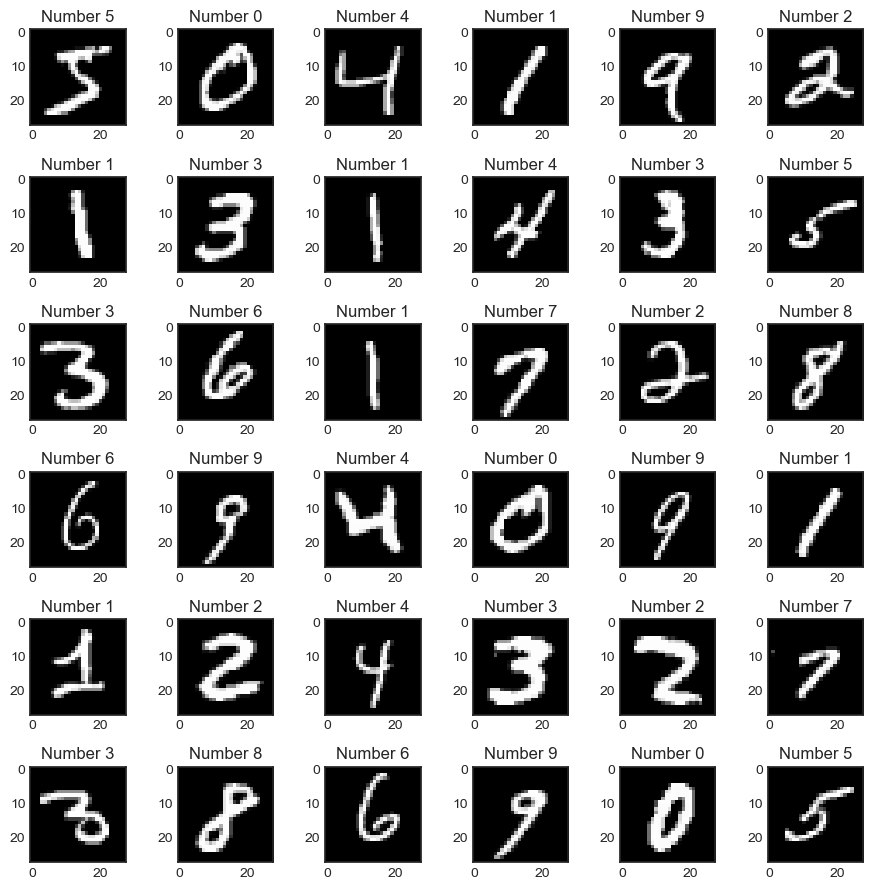

In [4]:
from keras.datasets import mnist

# Loading the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

# Displaying example images
show_images(X_train[:36], y_train[:36])

# Forming batches with the same label
X_batches = [[np.array(X, dtype=np.float32) for X, y in zip(X_test, y_test) if y == digit] for digit in range(10)]

## Step 2. Load embedding model

In [5]:
MODEL_PATH = 'models/embedding/v1'
embedding_model = tf.keras.models.load_model(MODEL_PATH)
embedding_model._name = 'embedding'
embedding_model.trainable = False
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 2048)              1607680   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
 unit_normalization (UnitNor  (None, 10)               0         
 malization)                                                     
                                                                 
Total params: 1,628,170
Trainable params: 0
Non-trainable params: 1,628,170
_______________________________________________

Just testing a performance of an embedding model:

In [6]:
EXAMPLE_PREDICTIONS_NUM = 10
prediction_ones = embedding_model.predict(np.array(X_batches[1][:EXAMPLE_PREDICTIONS_NUM]), verbose=0)
prediction_twos = embedding_model.predict(np.array(X_batches[2][:EXAMPLE_PREDICTIONS_NUM]), verbose=0)

display_header('Distances for numbers 1:')
for prediction in prediction_ones[:EXAMPLE_PREDICTIONS_NUM]:
    logging.info(prediction)
    
display_header('Distances for numbers 2:')
for prediction in prediction_twos[:EXAMPLE_PREDICTIONS_NUM]:
    logging.info(prediction)

2023-11-13 23:35:05.288901: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Distances for numbers 1:

[ 0.143 -0.346 -0.111 -0.084 -0.094  0.184 -0.27   0.606  0.338  0.494]
[ 0.1   -0.259 -0.133 -0.142 -0.1    0.111 -0.248  0.697  0.294  0.479]
[ 0.088 -0.363 -0.079 -0.071 -0.067  0.222 -0.215  0.651  0.315  0.475]
[ 0.057 -0.378 -0.117 -0.082 -0.094  0.209 -0.216  0.654  0.375  0.407]
[ 0.051 -0.316 -0.076 -0.072 -0.083  0.138 -0.215  0.682  0.33   0.49 ]
[ 0.048 -0.323 -0.163 -0.162 -0.123  0.081 -0.307  0.657  0.285  0.46 ]
[ 0.001 -0.364 -0.13  -0.166 -0.148  0.123 -0.265  0.653  0.303  0.445]
[ 0.05  -0.314 -0.168 -0.057 -0.045  0.144 -0.254  0.638  0.308  0.528]
[-0.378 -0.514 -0.097 -0.084  0.347  0.423 -0.048  0.355  0.327  0.206]
[ 0.062 -0.364 -0.15  -0.095 -0.067  0.157 -0.272  0.648  0.303  0.467]


### Distances for numbers 2:

[ 0.154 -0.338 -0.391  0.073  0.427  0.175 -0.225 -0.639  0.145 -0.104]
[-0.058 -0.356 -0.466  0.015  0.43   0.225 -0.284 -0.56   0.125 -0.079]
[-0.19  -0.539 -0.135  0.368  0.29   0.367  0.017 -0.503  0.113 -0.185]
[-0.046 -0.264 -0.497 -0.161  0.302  0.126 -0.495 -0.488  0.175  0.187]
[ 0.116 -0.393 -0.452  0.006  0.339  0.13  -0.37  -0.579  0.146 -0.044]
[ 0.008 -0.316 -0.497  0.179  0.214  0.386 -0.157 -0.62  -0.07  -0.104]
[ 0.239  0.236 -0.21  -0.292  0.644  0.057 -0.269 -0.23   0.199  0.418]
[ 0.042 -0.317 -0.547 -0.13   0.379  0.154 -0.351 -0.526  0.08  -0.088]
[ 0.101 -0.237 -0.648 -0.074  0.255  0.145 -0.389 -0.505 -0.093 -0.086]
[-0.168 -0.072 -0.383 -0.294  0.414 -0.104 -0.596 -0.398  0.165  0.103]


## Step 3. Defining a generator model

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 28, 28, 64)   640         ['input_2[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 28, 28, 64)   36928       ['conv2d_10[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 64)  0           ['conv2d_11[0][0]']              
                                                                                          

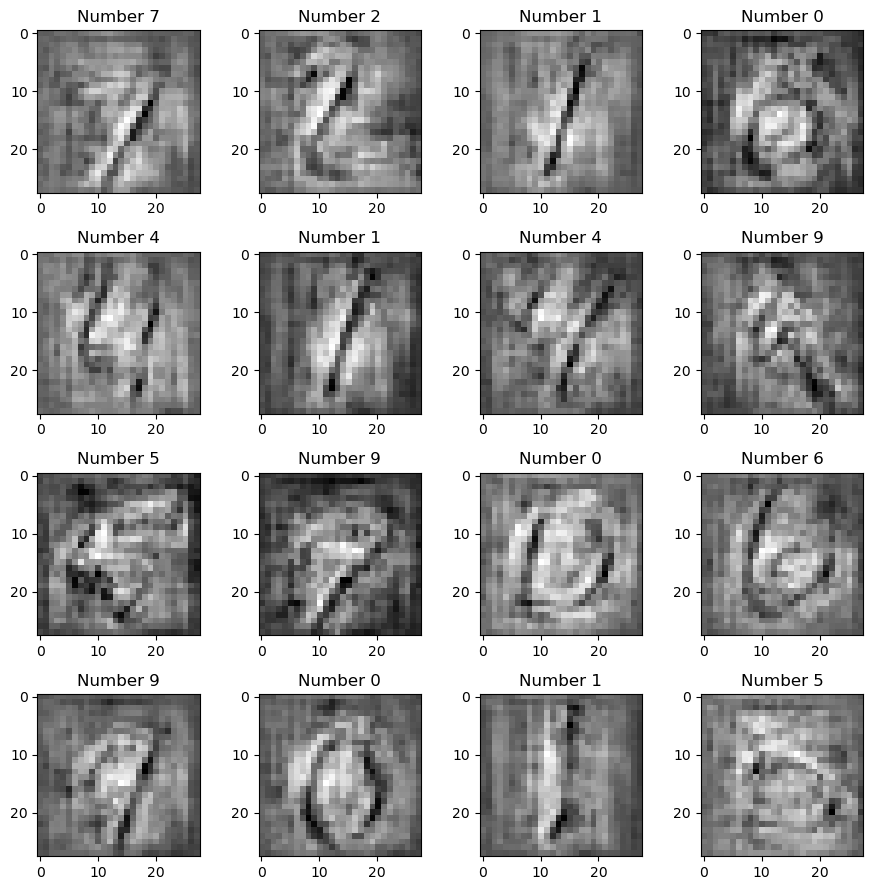

In [25]:
def Unet(input_shape=(28, 28, 1)):
    """
    Generates a generator that inputs an image and returns yet another image
    """
    
    # Define the input layer
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder (contracting path)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(conv3)

    # Decoder (expansive path)
    up4 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = tf.keras.layers.concatenate([up4, conv2], axis=3)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(up4)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(conv4)

    up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = tf.keras.layers.concatenate([up5, conv1], axis=3)
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(up5)
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(conv5)

    # Output layer
    output_image = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', name='output_image')(conv5)
    
    # Returning a retrieved model
    model = tf.keras.models.Model(inputs=inputs, outputs=output_image, name='generator')
    return model

# Instantiate the model
generator = Unet()

# Display the model summary
generator.summary()

# Display the example images
show_images(generator.predict(X_test[:16], verbose=0), y_test[:16])

In [26]:
def Trainer(generator, embedding_model, input_shape=(28, 28, 1)):
    # Define the input layer
    img_input = tf.keras.layers.Input(input_shape, name='image_input')

    # Define the output image from the generator
    output_image = generator(img_input)
    output_image._name = 'generated_image'

    # Embedding layer applied to the generated image
    embedding_generated = embedding_model(output_image)
    embedding_generated._name = 'generated_embedding'
    
    # Build a model
    model = tf.keras.models.Model(inputs=img_input, outputs=[output_image, embedding_generated])    
    return model

# Instantiate the model
trainer = Trainer(generator, embedding_model)

# Display the model summary
trainer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 generator (Functional)      (None, 28, 28, 1)         1881985   
                                                                 
 embedding (Sequential)      (None, 10)                1628170   
                                                                 
Total params: 3,510,155
Trainable params: 1,881,985
Non-trainable params: 1,628,170
_________________________________________________________________


## Step 4. Launching the training session

Forming the dataset:

In [27]:
embeddings_train = embedding_model.predict(np.array(X_train, dtype=np.float32), verbose=0)
y_train_merged = [X_train, embeddings_train]

Defining hyperparameters used for training:

In [28]:
hyperparams = {
    # Meta parameters
    "version": "v1.6",
    
    # Loss function parameters
    "threshold": 0.2,
    "lambda_img": -0.1,
    "lambda_emb": 1.0,
    
    # Training parameters
    "learning_rate": 1e-4,
    "epochs": 20,
    "batch_size": 64,
    "validation_split": 0.2
}

Defining the loss function

In [29]:
def SSIMLoss(y_true: any, y_pred: any) -> float:
    """
    Loss function for image comparison
    """
    
    return hyperparams['lambda_img'] * (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0, filter_size=7))) / 2.0

def MSEImageLoss(y_true: any, y_pred: any) -> float:
    """
    Loss function for image comparison
    """
    
    return hyperparams['lambda_img'] * tf.reduce_mean(tf.math.square(y_true - y_pred))

def ThresholdLoss(y_true: any, y_pred: any) -> float:
    """
    Loss function for embedded vectors comparison
    """
    
    differences = tf.math.reduce_sum(tf.math.square(y_true - y_pred), axis=1)
    differences = tf.nn.relu(differences - hyperparams['threshold'])
    return hyperparams['lambda_emb'] * tf.reduce_mean(differences) / 4.0

Testing losses on example batches:

In [30]:
# SSIM Loss testing
display_header('Example SSIM Losses:')
print(f'Loss between different digits: {SSIMLoss(X_batches[0][:32], X_batches[1][:32])}')
print(f'Loss between images of digit 0: {SSIMLoss(X_batches[0][:32], X_batches[0][32:64])}')
print(f'Loss between images of digit 1: {SSIMLoss(X_batches[1][:32], X_batches[1][32:64])}')

### Example SSIM Losses:

Loss between different digits: -0.043399423360824585
Loss between images of digit 0: -0.03682649880647659
Loss between images of digit 1: -0.018602633848786354


In [31]:
# MSE Loss testing
X_zeros = np.array([X for X, y in zip(X_test, y_test) if y == 0], dtype=np.float32)
X_ones = np.array([X for X, y in zip(X_test, y_test) if y == 1], dtype=np.float32)

display_header('Example MSE Losses:')
print(f'Loss between different digits: {MSEImageLoss(np.array(X_batches[0][:32]), np.array(X_batches[1][:32]))}')
print(f'Loss between images of digit 0: {MSEImageLoss(np.array(X_batches[0][:32]), np.array(X_batches[0][32:64]))}')
print(f'Loss between images of digit 1: {MSEImageLoss(np.array(X_batches[1][:32]), np.array(X_batches[1][32:64]))}')

### Example MSE Losses:

Loss between different digits: -0.01570349745452404
Loss between images of digit 0: -0.012416738085448742
Loss between images of digit 1: -0.004519284702837467


Defining the loss functions:

In [32]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=hyperparams['learning_rate'])
trainer.compile(optimizer=optimizer, loss={
    'generator': MSEImageLoss,
    'embedding': ThresholdLoss
})
history = trainer.fit(
    X_train,
    y_train_merged,
    batch_size=hyperparams['batch_size'],
    epochs=hyperparams['epochs'],
    validation_split=hyperparams['validation_split'],
    verbose=1
)
generator.save('models/generator/{}'.format(hyperparams['version']))

Epoch 1/20
750/750 [==============================] - 365s 487ms/step - loss: 0.1532 - generator_loss: -0.0484 - embedding_loss: 0.0087 - val_loss: 0.1383 - val_generator_loss: -0.0649 - val_embedding_loss: 0.0103
Epoch 2/20
750/750 [==============================] - 369s 492ms/step - loss: 0.1330 - generator_loss: -0.0652 - embedding_loss: 0.0054 - val_loss: 0.1296 - val_generator_loss: -0.0679 - val_embedding_loss: 0.0046
Epoch 3/20
750/750 [==============================] - 373s 498ms/step - loss: 0.1269 - generator_loss: -0.0704 - embedding_loss: 0.0044 - val_loss: 0.1249 - val_generator_loss: -0.0732 - val_embedding_loss: 0.0053
Epoch 4/20
750/750 [==============================] - 366s 488ms/step - loss: 0.1228 - generator_loss: -0.0736 - embedding_loss: 0.0035 - val_loss: 0.1226 - val_generator_loss: -0.0751 - val_embedding_loss: 0.0048
Epoch 5/20
750/750 [==============================] - 366s 487ms/step - loss: 0.1202 - generator_loss: -0.0756 - embedding_loss: 0.0029 - val_lo

2023-11-14 10:51:15.756952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-11-14 10:51:15.762860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-11-14 10:51:16.014897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-11-14

INFO:tensorflow:Assets written to: models/generator/v1.6/assets


History contains the following keys: dict_keys(['loss', 'generator_loss', 'embedding_loss', 'val_loss', 'val_generator_loss', 'val_embedding_loss'])


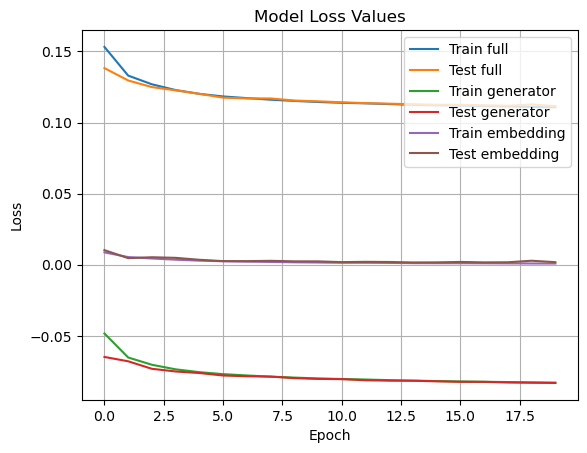

In [49]:
# Print what keys the history dictionary contains
logging.info(f'History contains the following keys: {history.history.keys()}')

# Summarize history for loss in a plot
pyplot.style.use('default')
pyplot.grid()
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.plot(history.history['generator_loss'])
pyplot.plot(history.history['val_generator_loss'])
pyplot.plot(history.history['embedding_loss'])
pyplot.plot(history.history['val_embedding_loss'])

pyplot.title('Model Loss Values')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train full', 'Test full', 'Train generator', 'Test generator', 'Train embedding', 'Test embedding'], loc='upper right')
pyplot.show()

## 5. Analyzing results

### 5.1. Generated images visualization
First, we plot example predictions

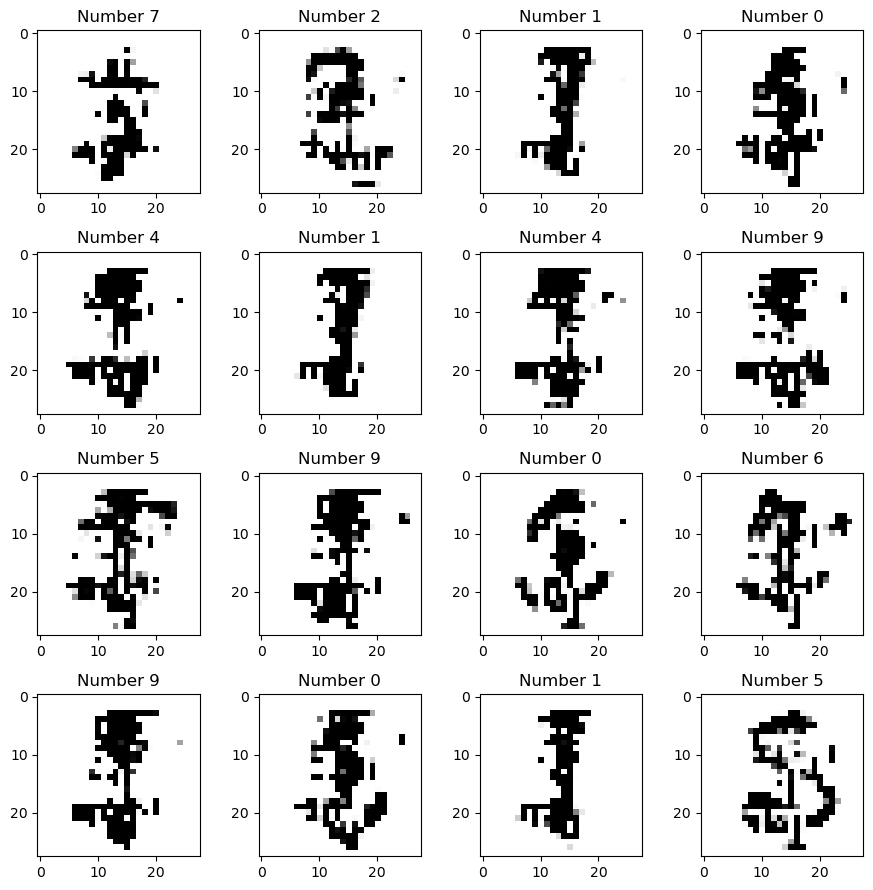

In [34]:
show_images(generator.predict(X_test[:16], verbose=0), y_test[:16])

Then, we show example transformation for all digits:

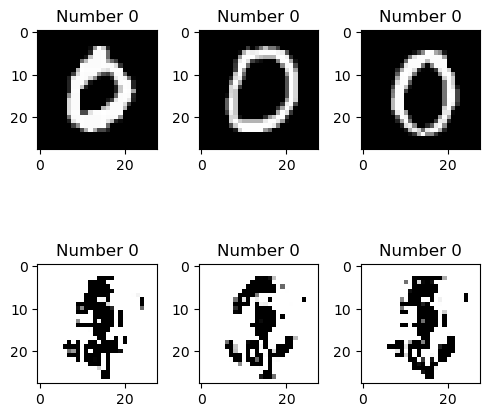

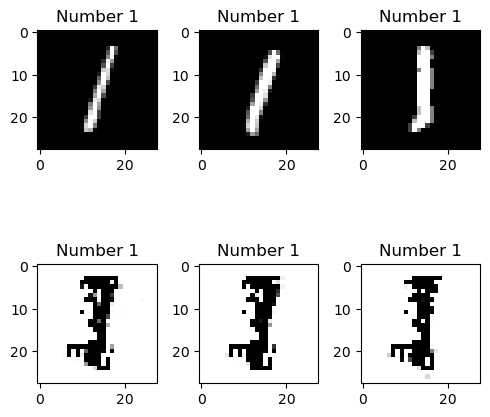

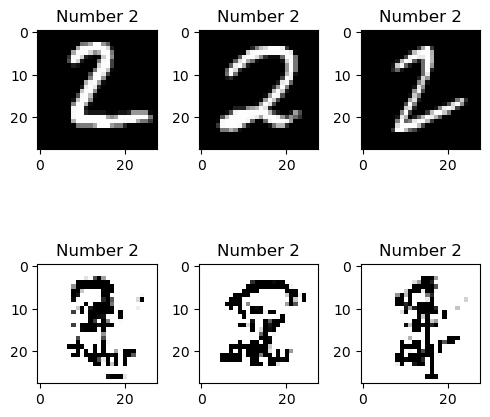

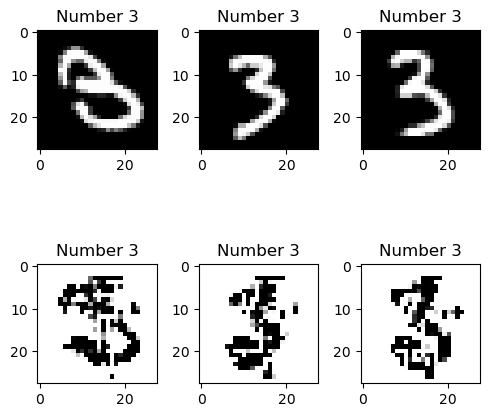

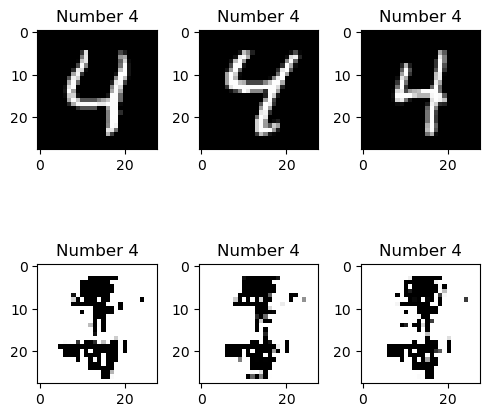

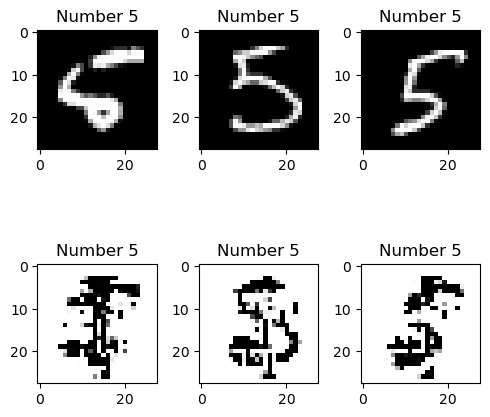

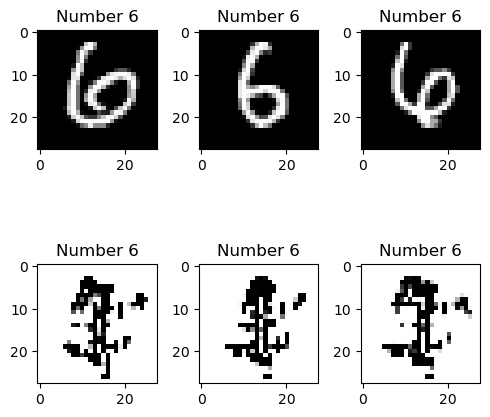

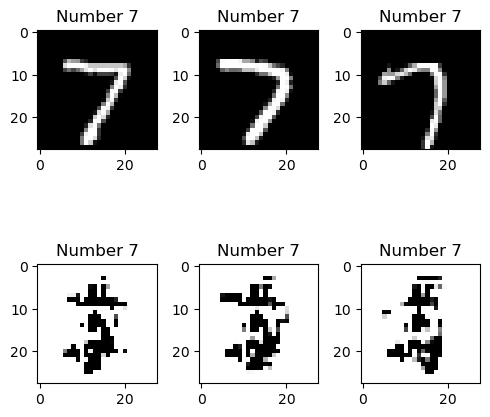

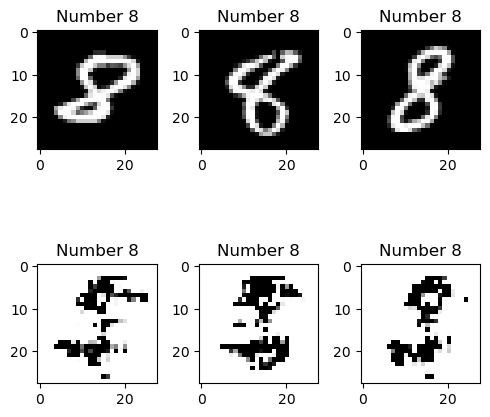

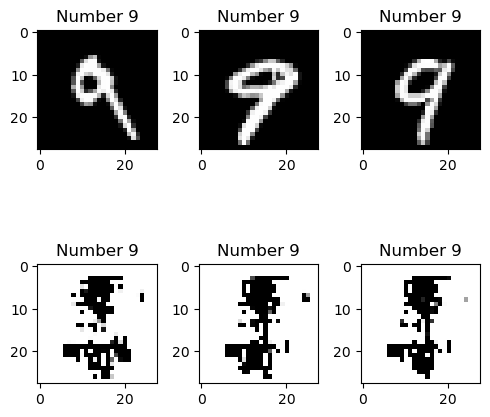

In [35]:
for digit in range(10):
    predictions = generator.predict(np.array(X_batches[digit][:3], dtype=np.float32), verbose=0)
    show_images([*X_batches[digit][:3], *predictions], [digit]*6, size=(5,5))

### 5.2. Drawing a PCA plot

/var/folders/v0/zz8w2jg50k15rrlj48nht3l00000gn/T/ipykernel_15936/3606288106.py:51: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(
/var/folders/v0/zz8w2jg50k15rrlj48nht3l00000gn/T/ipykernel_15936/3606288106.py:60: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(x_data[from_n:to_n], y_data[from_n:to_n], z_data[from_n:to_n], c=colors[-1], label=f'Number {digits_to_draw[-1]} (generated)', cmap='jet')


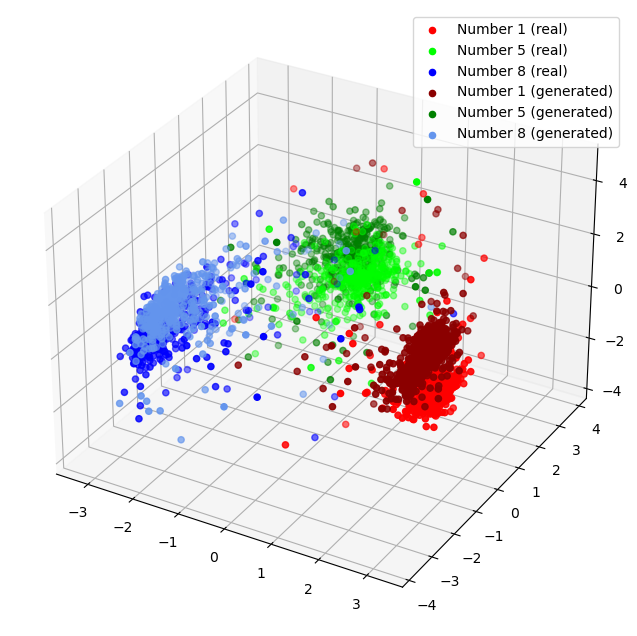

In [36]:
# Taking a subset of dataset to display the PCA plot
X_pca = X_train[:5000]
y_pca = y_train[:5000]

# Making embeddings
embedding_real = embedding_model.predict(X_pca, verbose=0)
embedding_generated = embedding_model.predict(generator.predict(X_pca, verbose=0), verbose=0)

digits_to_draw = [1, 5, 8] # Defining digits to display
colors_real = ['r', 'lime', 'b'] # Colors of points corresponding to real numbers
colors_generated = ['darkred', 'green', 'cornflowerblue'] # Colors of points corresponding to generated

# Forming predictions in a manner PCA wants them to see
predictions_batches, colors = [], []
for i, digit in enumerate(digits_to_draw):
    predictions_batch_real = [prediction for prediction, y in zip(embedding_real, y_pca) if digit == y]
    
    predictions_batches.append(predictions_batch_real)
    colors.append([i] * len(predictions_batch_real))
    
for i, digit in enumerate(digits_to_draw):
    predictions_batch_generated = [prediction for prediction, y in zip(embedding_generated, y_pca) if digit == y]
    
    predictions_batches.append(predictions_batch_generated)
    colors.append([i] * len(predictions_batch_generated))

flattenned_predictions = [item for batch in predictions_batches for item in batch]
flattenned_colors = [item for batch in colors for item in batch]

# Launching PCA
pca = PCA(n_components=3)
pca = sklearn.decomposition.PCA(n_components=3)
batch_scaled = sklearn.preprocessing.StandardScaler().fit_transform(flattenned_predictions)
pca_features = pca.fit_transform(batch_scaled)

# Getting scaled features
x_data = pca_features[:,0]
y_data = pca_features[:,1]
z_data = pca_features[:,2]
 
# Plot 3D plot
pyplot.style.use('default')
fig = pyplot.figure(figsize=(10,8))
ax = pyplot.axes(projection='3d')

from_n, to_n = 0, len(predictions_batches[0])
colors = [*colors_real, *colors_generated]

for i in range(len(predictions_batches)-1):
    _x, _y, _z = x_data[from_n:to_n], y_data[from_n:to_n], z_data[from_n:to_n], 
    ax.scatter3D(
        _x, _y, _z,
        c=colors[i], 
        label=f'Number {digits_to_draw[i%3]} ' + ('(real)' if i < 3 else '(generated)'), 
        cmap='jet'
    )
    from_n = to_n
    to_n = to_n + len(predictions_batches[i+1])

ax.scatter3D(x_data[from_n:to_n], y_data[from_n:to_n], z_data[from_n:to_n], c=colors[-1], label=f'Number {digits_to_draw[-1]} (generated)', cmap='jet')
ax.legend()

# Saving the pca plot
figure_path = Path('images/generator/{}'.format(hyperparams['version']))
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
pyplot.savefig(figure_path/'pca.png')

# Showing a plot
pyplot.show()

## 6. Saving example figures and hyperparams

In [20]:
from pathlib import Path

NUM_IMAGES_TO_SAVE = 10 # Number of digits pairs (real - generated) to save

base_path = Path('images/generator/{}'.format(hyperparams['version']))
for digit in range(10):
    # Making sure we have a place to save images in
    directory_path = base_path / str(digit)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    
    # Preparing a set of images to save
    X_digit = X_batches[digit][:NUM_IMAGES_TO_SAVE]
    X_digit_generated = generator.predict(np.array(X_digit), verbose=0)
    
    X_digit = tf.image.resize(X_digit, [256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    X_digit_generated = tf.image.resize(X_digit_generated, [256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # Saving images
    for i, (X, X_generated) in enumerate(zip(X_digit, X_digit_generated)):
        real_image_name, generated_image_name = f'{i}_real.png', f'{i}_generated.png'
        pyplot.imsave(directory_path / real_image_name, np.squeeze(X, axis=-1), cmap='gray')
        pyplot.imsave(directory_path / generated_image_name, np.squeeze(X_generated, axis=-1), cmap='gray')

In [21]:
# Saving hyperparameters
hyperparams_file_path = base_path / 'hyperparams.json'
with open(hyperparams_file_path, "w") as file:
    json.dump(hyperparams, file)